<a href="https://colab.research.google.com/github/ArunGovardhanRajObuli/Projects/blob/main/CIFAR_10_Neural_Networks_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Basic Architecture without Improvements

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100] Train Acc: 32.69%, Test Acc: 38.14%
Epoch [2/100] Train Acc: 40.60%, Test Acc: 42.12%
Epoch [3/100] Train Acc: 44.42%, Test Acc: 44.17%
Epoch [4/100] Train Acc: 47.22%, Test Acc: 47.35%
Epoch [5/100] Train Acc: 49.31%, Test Acc: 47.11%
Epoch [6/100] Train Acc: 50.62%, Test Acc: 47.86%
Epoch [7/100] Train Acc: 51.52%, Test Acc: 50.63%
Epoch [8/100] Train Acc: 52.83%, Test Acc: 51.04%
Epoch [9/100] Train Acc: 53.41%, Test Acc: 51.02%
Epoch [10/100] Train Acc: 54.20%, Test Acc: 46.72%
Epoch [11/100] Train Acc: 54.76%, Test Acc: 54.17%
Epoch [12/100] Train Acc: 55.62%, Test Acc: 52.90%
Epoch [13/100] Train Acc: 56.09%, Test Acc: 53.03%
Epoch [14/100] Train Acc: 56.71%, Test Acc: 56.43%
Epoch [15/100] Train Acc: 57.45%, Test Acc: 56.57%
Epoch [16/100] Train Acc: 57.84%, Test Acc: 53.88%
Epoch [17/100] Train Acc: 58.24%, Test Acc: 56.34%
Epoch [18/100] Train Acc: 58.76%, Test Acc: 55.

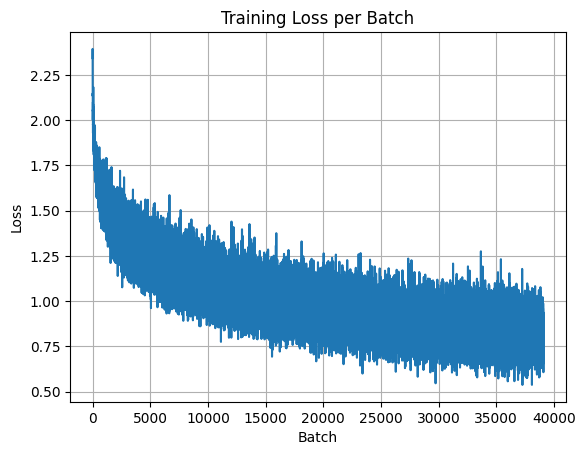

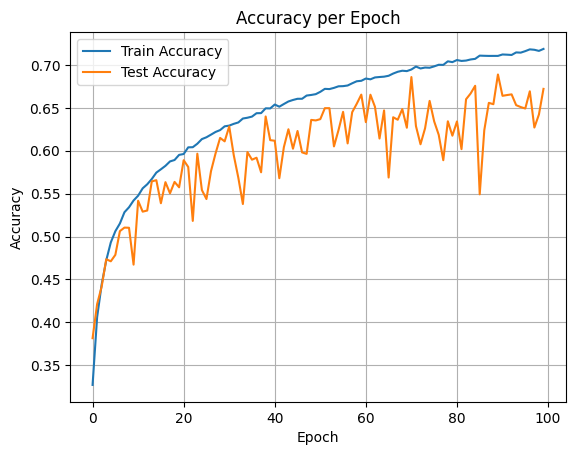

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


torch.manual_seed(42) # We are setting a PyTorch random seed for reproducibility.
np.random.seed(42) # Setting a NumPy's random seed for reproducibility.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Choosing the GPU if available, as the first option the run the model, else we use the CPU.
print("Using device:", device)


def load_data_cifar10(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(), # We convert the PIL image to a PyTorch Tensor.
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616)) # Normalizing with dataset-specific mean & std.
    ])
    train_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=transform, download=True
    )# Creating the training set.
    test_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=transform, download=True
    )# Creating the test set.

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2) # Wrapping it in DataLoader for batching and shuffling.
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=2) # Wrapping it in DataLoader for batching  only.
    return train_loader, test_loader


class IntermediateBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_sizes=[3], num_conv_layers=1):
        super(IntermediateBlock, self).__init__()
        self.num_branches = num_conv_layers # Storing the number of convolution branches that we will use.
        self.branches = nn.ModuleList() # Creating an empty ModuleList to hold all convolution branches (each branch is a sequential block).

        # Each "branch" is one convolutional path
        for _ in range(num_conv_layers):
            conv = nn.Conv2d(in_channels, out_channels,
                             kernel_size=kernel_sizes[0],
                             padding=kernel_sizes[0]//2, bias=False) # Creating a convolutional layer with the specified input, output channels,kernel size and padding.
            bn = nn.BatchNorm2d(out_channels) # Adding a Batch Normalization layer over the output channels for stable training.
            relu = nn.ReLU(inplace=True) # Applying an in-place ReLU non-linearity for activation.
            self.branches.append(nn.Sequential(conv, bn, relu)) # Bundling the layers into a sequential container and add the branch to the list.


        self.fc = nn.Linear(in_channels, num_conv_layers) # Creating a fully connected (FC) layer that takes the channel-wise means of the input and outputs a set of coefficients (one for each branch).
        self.softmax = nn.Softmax(dim=1) # Applying a Softmax over the branch coefficients so they sum to one.

    def forward(self, x):

        branch_outs = [branch(x) for branch in self.branches] # Processing the input x through each convolution branch, collecting the outputs in a list.

        batch_size, c, _, _ = x.shape
        c_means = x.mean(dim=(2, 3))  # Compute the mean of x over its spatial dimensions (height and width).


        a = self.softmax(self.fc(c_means)) # Passing the channel means through the FC layer, producing an output for each branch.Then apply the softmax so that the coefficients (stored in a) are normalized across branches. This tensor has shape (batch_size, num_branches).


        out = torch.zeros_like(branch_outs[0]) # Initializing an output tensor with zeros having the same shape as one branch output.
        for i in range(self.num_branches): # For each branch, we multiply the branch output by its corresponding learned coefficient. The coefficient a[:, i] is reshaped to allow broadcasting over the spatial dimensions. Then, we add these weighted outputs together.
            out += a[:, i].view(batch_size, 1, 1, 1) * branch_outs[i]
        return out

class OutputBlock(nn.Module):

    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        self.fc = nn.Linear(in_channels, num_classes)  # Creating a fully connected layer that converts the pooled features into logits.

    def forward(self, x):
        batch_size, c, _, _ = x.shape # Getting the shape of the tensor x.
        c_means = x.mean(dim=(2, 3)) # Performing global average pooling by computing the mean over the height and width dimensions. This reduces the tensor to a shape of (batch_size, c).
        logits = self.fc(c_means) # Projecting the pooled features to produce logits for each class.
        return logits


class BasicNet(nn.Module):

    def __init__(self):
        super(BasicNet, self).__init__()
        self.block1 = IntermediateBlock(in_channels=3, out_channels=32,
                                        kernel_sizes=[3], num_conv_layers=2) # First intermediate block takes in 3-channel input (e.g., RGB image) and outputs 32 channels and uses 2 parallel convolutional layers.
        self.block2 = IntermediateBlock(in_channels=32, out_channels=64,
                                        kernel_sizes=[3], num_conv_layers=2) # Second intermediate block accepts the output of the first block (32 channels) and outputs 64 channels, and also employs 2 convolutional branches.
        self.output_block = OutputBlock(in_channels=64, num_classes=10) # The output block takes in the 64-channel feature map and produces logits for 10 classes.

    def forward(self, x):
        x = self.block1(x) # Processing the input through the first intermediate block.
        x = self.block2(x) # Then, we pass the result through the second intermediate block.
        x = self.output_block(x) # Finally, we obtain the final class logits using the output block.
        return x

def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

def eval_Metric(model, data_loader, criterion):

    model.eval() # Setting the model to evaluation mode.
    correct, total = 0, 0 # Initializing counters for the number of correct predictions, total samples and the running sum of losses.
    running_loss = 0.0

    with torch.no_grad(): # Temporarily disable gradient calculations for efficiency during evaluation.
        for images, labels in data_loader: # Iterating over the data loader, which returns batches of images and corresponding labels.
            images, labels = images.to(device), labels.to(device) # Moving the images and labels to the designated device (e.g., GPU or CPU).
            logits = model(images) # We obtain the predicted logits from the model.
            loss = criterion(logits, labels) # Computing the loss for the current batch using the provided loss function (criterion).
            running_loss += loss.item() * images.size(0) # Accumulate the loss, multiplied by the number of examples in the batch.
            _, predicted = logits.max(1) # Determining the predicted class for each image by taking the index with the highest logit.
            correct += predicted.eq(labels).sum().item() # Updating the count of correctly classified images by comparing predictions with true labels.
            total += labels.size(0)  # Increase the total count of examples processed.

    avg_loss = running_loss / total # Calculating the average loss over all examples.
    acc = correct / total # Calculating the accuracy.
    model.train() # Setting the model back to training mode.
    return avg_loss, acc



if __name__ == "__main__":

    train_loader, test_loader = load_data_cifar10(batch_size=128) # Loading the data.

    model = BasicNet().to(device) # Creating model and move to GPU if available.
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss() # Defining a loss function.
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # Defining an optimizer.

    num_epochs = 100

    batch_losses = []  # List to store per-batch training loss.
    train_accs = []    # List to store per-epoch training accuracy.
    test_accs = []     # List to store per-epoch testing accuracy.

    # Looping over the desired number of epochs.
    for epoch in range(num_epochs):

        model.train()
        correct, total = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)


            optimizer.zero_grad()# Clearing old gradients.
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward() # Backprop for gradient computation.
            optimizer.step() # Apply the optimizer update step


            batch_losses.append(loss.item()) # Recording per-batch loss.

            # Tracking the training accuracy for this batch.
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)


        train_acc = correct / total # Computing end-of-epoch training accuracy.


        test_loss, test_acc = eval_Metric(model, test_loader, criterion)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")


    # Plotting training loss (per batch).
    plt.figure()
    plt.plot(batch_losses)
    plt.title("Training Loss per Batch")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Plotting train/test accuracy (per epoch).
    plt.figure()
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(test_accs, label="Test Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()


Improved Architecture

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
Epoch [1/100] -> Train Acc: 49.78%, Test Acc: 55.22%
Epoch [2/100] -> Train Acc: 58.46%, Test Acc: 64.12%
Epoch [3/100] -> Train Acc: 63.99%, Test Acc: 69.14%
Epoch [4/100] -> Train Acc: 65.58%, Test Acc: 71.21%
Epoch [5/100] -> Train Acc: 67.63%, Test Acc: 72.98%
Epoch [6/100] -> Train Acc: 73.14%, Test Acc: 77.51%
Epoch [7/100] -> Train Acc: 71.14%, Test Acc: 76.92%
Epoch [8/100] -> Train Acc: 69.94%, Test Acc: 76.76%
Epoch [9/100] -> Train Acc: 76.38%, Test Acc: 81.12%
Epoch [10/100] -> Train Acc: 70.01%, Test Acc: 75.57%
Epoch [11/100] -> Train Acc: 76.16%, Test Acc: 81.62%
Epoch [12/100] -> Train Acc: 78.22%, Test Acc: 82.42%
Epoch [13/100] -> Train Acc: 76.18%, Test Acc: 80.24%
Epoch [14/100] -> Train Acc: 79.78%, Test Acc: 83.26%
Epoch [15/100] -> Train Acc: 71.78%, Test Acc: 77.81%
Epoch [16/100] -> Train Acc: 77.75%, Test Acc: 82.10%
Epoch [17/100] -> Train Acc: 82.24%, Test Acc: 85.

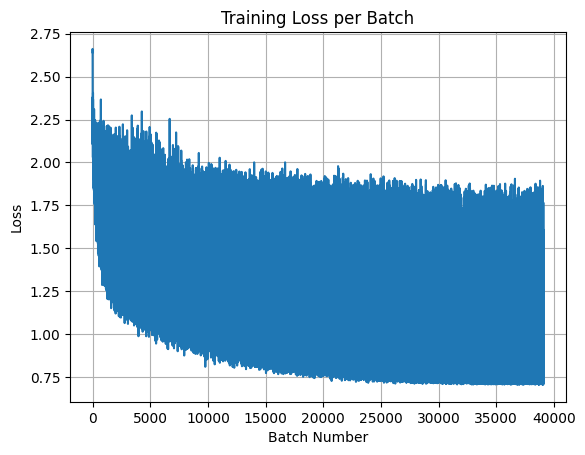

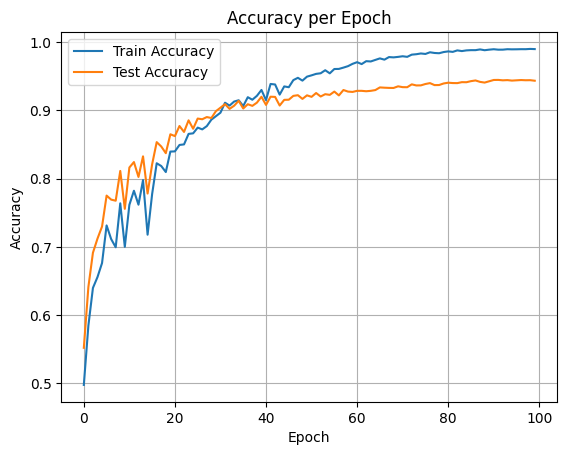

Highest Test Accuracy: 94.45%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader


torch.manual_seed(42) # We are setting a PyTorch random seed for reproducibility.
np.random.seed(42) # Setting a NumPy's random seed for reproducibility.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Choosing the GPU if available, as the first option the run the model, else we use the CPU.
print("Using device:", device)


def mixup_data(x, y, alpha=0.2):
    '''
    We are creating mixed-up inputs and corresponding targetsfrom a mini-batch
    to improve generalization by linearly interpolating between examples and labels.
    '''

    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # Here, we sample a lambda from Beta distribution.
    else:
        lam = 1 # If alpha is greater than or equal to 0 then we do not apply mixup.
    batch_size = x.size(0) # Number of images in the batch.
    index = torch.randperm(batch_size).to(device) # Generating a random permutation of batch indices.
    mixed_x = lam * x + (1 - lam) * x[index, :] # We are combining the original batch x with a shuffled version x[index,:] using lam as a weight.
    y_a, y_b = y, y[index] # We are retaining both original labels y and permuted labels y[index] because final label is also an interpolation to match mixup of images.
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    We compute the mixup loss by interpolating the loss from two label sets.
    This aligns with how mixup_data interpolates the images and labels.
    """

    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


class Cutout(object):
    """
    We use this to randomly mask out squares or holes from the image.
    We do this because it acts as a form of data augmentation that makes the model robust to occlusions.
    """

    def __init__(self, n_holes, length):
        self.n_holes = n_holes # Number of rectangular holes to cut out.
        self.length = length # Length or pixels of each hole.

    def __call__(self, img):
        h, w = img.size(1), img.size(2) # We extract height & width from the input tensor.
        mask = np.ones((h, w), np.float32) # Initializing a 'mask' of ones. This effectively means "keep all pixels".
        for _ in range(self.n_holes):
            # Randomly choosing a hole's center.
            y = np.random.randint(h)
            x = np.random.randint(w)
            # Computing the top-left and bottom-right corners of the hole.
            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)
            mask[y1:y2, x1:x2] = 0. # Zero out or masking that square region.
        mask = torch.from_numpy(mask).expand_as(img) # Here, we are converting it to tensor and expanding to shape of 'img'
        return img * mask # Multiplying by 'img' so that masked-out sections become 0.


def load_data_cifar10(batch_size=128, use_cutout=True, cutout_length=8, cutout_n_holes=1):
    """
    We are loading the CIFAR-10 training & testing sets and applying transformations
    such as RandAugment, random cropping, flipping, cutout and normalization to
    significantly improve the generalization performance.
    """

    train_transform = transforms.Compose([
        transforms.RandAugment(num_ops=2, magnitude=7), # Applying 2 random augmentations with magnitude=7.
        transforms.RandomCrop(32, padding=4), # We are cropping 32x32 from a padded image.
        transforms.RandomHorizontalFlip(), # Flipping images horizontally.
        transforms.ToTensor(), # Converting PIL image to a PyTorch tensor.
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616)) # Normalizing with dataset-specific mean & std.
    ])
    if use_cutout:
        train_transform.transforms.append(Cutout(cutout_n_holes, cutout_length)) # We can append cutout transform if desired.

    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    train_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=train_transform, download=True
    ) # Creating the training set.
    test_dataset = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=test_transform, download=True
    ) # Creating the testing set.

    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=2) # Wrapping it in DataLoader for batching and shuffling.
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, num_workers=2) # Wrapping it in DataLoader for batching. We do not shuffle the test set.

    return train_loader, test_loader


class IntermediateBlock(nn.Module):
    """
    Each block has multiple convolutional 'branches' with different kernel sizes
    or repeated conv layers, all having the same input. These are then weighted
    by a learned set of coefficients that depends on the input's channel averages.
    By using this architecture can capture different features while letting the
    model learn how to weight each branch's output.
    """

    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5], num_conv_layers=2):
        super(IntermediateBlock, self).__init__()
        self.num_branches = len(kernel_sizes) # Number of parallel branches.
        self.branches = nn.ModuleList() # Holding each branch as a sub-network.

        for k in kernel_sizes:
            # Each branch might have multiple conv layers as defined by 'num_conv_layers'.
            layers = []
            current_in = in_channels
            for _ in range(num_conv_layers):
                # Convolution with specified kernel size, BN, ReLU.
                layers.append(nn.Conv2d(current_in, out_channels, kernel_size=k,
                                        padding=k//2, bias=False))
                layers.append(nn.BatchNorm2d(out_channels))
                layers.append(nn.ReLU(inplace=True))
                current_in = out_channels
            self.branches.append(nn.Sequential(*layers)) # Combining these layers in a Sequential.

        self.fc = nn.Linear(in_channels, self.num_branches) # The fc layer takes per-channel means of the input and outputs 'num_branches' weights.
        self.softmax = nn.Softmax(dim=1) # Applying softmax so the weights a_i sum to 1 across the branches.

    def forward(self, x):
        branch_outputs = [branch(x) for branch in self.branches]  # For each branch, we compute its feature map from x.
        batch_size = x.size(0)
        c_means = x.mean(dim=(2, 3)) # Computing the mean of each channel in x to form a vector.
        a = self.softmax(self.fc(c_means))  # FC transforms that channel-mean vector into a set of branch coefficients with shape (batch_size, num_branches).

        # Weighted combination of the branch outputs
        out = 0
        for i in range(self.num_branches):
            # Expanding a[:, i] so it can multiply the i-th branch output
            out += a[:, i].view(batch_size, 1, 1, 1) * branch_outputs[i]
        return out

class OutputBlock(nn.Module):
    """
    This block receives the final feature map from the last intermediate block,
    performs global average pooling, then a linear layer to produce logits.
    This compresses the spatial dimension into channels, then classifies into 10 classes.
    """

    def __init__(self, in_channels, num_classes=10):
        super(OutputBlock, self).__init__()
        self.fc = nn.Linear(in_channels, num_classes) # Final classification layer

    def forward(self, x):
        batch_size = x.size(0)
        c_means = x.mean(dim=(2, 3)) # Averaging each channel across H,W with shape: (batch_size, in_channels).
        return self.fc(c_means)  # Passing the pooled vector into the linear layer to get logits.


class ImprovedBasicNet(nn.Module):
    """
    We are using 4 intermediate blocks, each with potential multiple conv layers & parallel branches,
    plus max pooling in between the first 3 blocks, and a final output block. By doing this we can
    create a deeper, more flexible architecture that can handle complex feature extraction
    on CIFAR-10 dataset.
    """

    def __init__(self, num_conv_layers_per_block=2):
        super(ImprovedBasicNet, self).__init__()
        # First block and pooling.
        self.block1 = IntermediateBlock(3, 64, kernel_sizes=[3, 5],
                                        num_conv_layers=num_conv_layers_per_block)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second block and pooling.
        self.block2 = IntermediateBlock(64, 128, kernel_sizes=[3, 5],
                                        num_conv_layers=num_conv_layers_per_block)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third block and pooling.
        self.block3 = IntermediateBlock(128, 256, kernel_sizes=[3, 5],
                                        num_conv_layers=num_conv_layers_per_block)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fourth block with no pooling.
        self.block4 = IntermediateBlock(256, 512, kernel_sizes=[3, 5],
                                        num_conv_layers=num_conv_layers_per_block)

        # We are adding a global average pooling and dropout.
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.output_block = OutputBlock(512, num_classes=10) # Output block.

    def forward(self, x):
        x = self.pool1(self.block1(x)) # Passing x through first block and then pooling.
        x = self.pool2(self.block2(x)) # Passing x through second block and then pooling.
        x = self.pool3(self.block3(x)) # Passing x through third block and then pooling.
        x = self.block4(x) # Passing x through fourth block with no pooling.
        x = self.global_avg_pool(x) # Global average pooling to get (batch_size, channel)
        x = self.dropout(x) # Adding a 50% dropout for regularization.
        return self.output_block(x) # Output block returns the final logits.


def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

def evaluate_metric(model, data_iter):
    """
    We compute the accuracy on the given data_iter which is either the
    train or test loader to measure the model performance per epoch.
    """

    correct = 0
    total = 0
    model.eval() # Disabling the dropout, etc. for eval.
    with torch.no_grad(): # Disabling gradient computation to make it run faster and use less memory.
        for inputs, labels in data_iter:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1) # Getting the index of the highest logit as the prediction.
            correct += predicted.eq(labels).sum().item() # Counting the correct predictions.
            total += labels.size(0) # Keep track of how many examples we see.
    model.train() # Switching back to training mode.
    return correct / total




if __name__ == "__main__":
    batch_size = 128 # Defining the number of examples per batch.
    num_epochs = 100 # Defining the number of iterations over the dataset.
    base_lr = 0.004 # Setting the base learning rate for OneCycleLR and Adam.

    train_loader, test_loader = load_data_cifar10(
        batch_size=batch_size, use_cutout=True, cutout_length=8, cutout_n_holes=1
    ) # Loading the data.

    model = ImprovedBasicNet(num_conv_layers_per_block=2).to(device) # Creating the improved model with 2 convolutional layers in each branch.
    model.apply(init_weights)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15) # Defining the Loss function with label smoothing for better generalization.
    optimizer = optim.Adam(model.parameters(), lr=base_lr) # Defining the optimizer.

    steps_per_epoch = len(train_loader)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=base_lr,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch
    ) # OneCycleLR changes the learning rate from zero up to max_lr, then down again over the course of training to potentially yield faster convergence.


    batch_losses = []   # List to store training loss per batch.
    train_accs = []     # List to store training accuracy per epoch.
    test_accs = []      # List to store testing accuracy per epoch.

    # Looping over the desired number of epochs.
    for epoch in range(num_epochs):
        model.train()
        correct_mix = 0.0
        total_mix = 0


        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Moving images and labels to GPU if it is available.
            inputs, targets = inputs.to(device), targets.to(device)

            mixed_inputs, targets_a, targets_b, lam = mixup_data(inputs, targets, alpha=0.1) # Applying Mixup augmentation.
            # Forward pass
            outputs = model(mixed_inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam) # Computing mixup loss.

            optimizer.zero_grad() # Clearing old gradients.
            loss.backward() # Backprop for gradient computation.
            optimizer.step() # Apply the optimizer update step
            scheduler.step()  # Update the learning rate schedule each batch

            batch_losses.append(loss.item()) # Recording batch loss.

            # Approximate "mixup accuracy" (This is an optional step and is not being used for final metrics).
            _, predicted = outputs.max(1)
            total_mix += targets.size(0)
            correct_mix += lam * predicted.eq(targets_a).sum().item() + \
                           (1 - lam) * predicted.eq(targets_b).sum().item()


        train_acc = evaluate_metric(model, train_loader) # Evaluating on entire training set for an epoch-level train accuracy.
        test_acc = evaluate_metric(model, test_loader) # Evaluating on test set.
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] -> "
              f"Train Acc: {train_acc*100:.2f}%, Test Acc: {test_acc*100:.2f}%")

    # Plotting training loss for every batch.
    plt.figure()
    plt.plot(batch_losses)
    plt.title("Training Loss per Batch")
    plt.xlabel("Batch Number")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    # Plotting train/test accuracy curves.
    plt.figure()
    plt.plot(train_accs, label="Train Accuracy")
    plt.plot(test_accs, label="Test Accuracy")
    plt.title("Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Highest Test Accuracy: {max(test_accs)*100:.2f}%")